In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:


from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



from utils import generate_bpr_dataset, generate_bpr_dataset_with_click_data
from bpr_mf import bprMF, bprMFDataloader, bpr_loss_with_reg, bpr_train, bpr_loss_with_reg

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item"]]

## Developing a simple matrix factorization with pytorch


We'll start developing a matrix factorization model which focused on regressions tasks using pytorch for modelling and MSE for loss.

In [5]:
from simple_mf import MF, MFDataLoader

In [6]:

def train(dataloader, model, loss_fn, optimizer, n_epochs=10):
    batch_losses = [] 
    epoch_losses = []
    model.train()
    for epoch in range(n_epochs):

        epoch_loss = []
        for batch, ((user_ids, item_ids), ratings) in enumerate(dataloader):
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.to(device).float()

            pred = model(user_ids, item_ids)
            loss = loss_fn(pred, ratings)

            epoch_loss.append(loss.item())
            batch_losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss = sum(epoch_loss) / len(epoch_loss)
        epoch_losses.append(epoch_loss)
        print(f"epoch mean loss: {epoch_loss:>7f}; Epoch: {epoch+1}/{n_epochs}")
    return batch_losses, epoch_losses
        


In [7]:
data = MFDataLoader('movielens_1m_ratings.csv')
dataloader = DataLoader(data, batch_size=256, shuffle=True)

In [8]:
model = MF(num_users=data.n_users, num_items=data.n_items, factors=30).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [9]:
b_loss, e_loss = train(dataloader, model, loss_fn, optimizer)

epoch mean loss: 3.412419; Epoch: 1/10
epoch mean loss: 1.396009; Epoch: 2/10


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

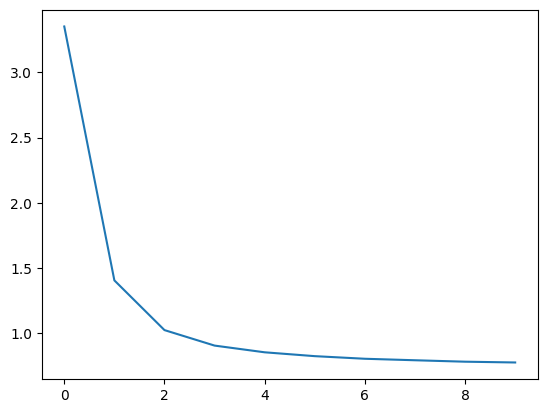

In [ ]:
plt.plot(e_loss, label='epoch loss')

## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [11]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

bpr_df = generate_bpr_dataset(interactions)

In [12]:
bpr_df["user"].values

array([   1,    1,    1, ..., 6040, 6040, 6040], shape=(3000627,))

### Step 2: Create a MF model using BPR loss function

In [15]:
bpr_df

,user,pos_item,neg_item
0,1,0,1462
1,1,0,3641
2,1,0,1897
3,1,1,2160
4,1,1,1134
...,...,...,...
3000622,6040,152,2202
3000623,6040,152,1837
3000624,6040,26,2562
3000625,6040,26,2205


In [ ]:
data_bpr = bprMFDataloader(bpr_df)


# Calculate split lengths
train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



In [18]:


dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [19]:

n_users = bpr_df.user.max() + 1
n_items = bpr_df.pos_item.max() + 1

In [20]:
n_users, n_items

(np.int64(6041), np.int64(3706))

In [32]:
model = bprMF(num_users=n_users, num_items=n_items, factors=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
train_loss, test_loss = bpr_train(dataloader_bpr_train, dataloader_bpr_test, model, bpr_loss_with_reg, optimizer, reg_lambda=5e-4, debug=True)

Train epoch mean loss: 0.339638;
 Test epoch mean loss: 0.265157; Epoch: 1/10
Train epoch mean loss: 0.239879;
 Test epoch mean loss: 0.226896; Epoch: 2/10
Train epoch mean loss: 0.203948;
 Test epoch mean loss: 0.203598; Epoch: 3/10
Train epoch mean loss: 0.180602;
 Test epoch mean loss: 0.192519; Epoch: 4/10
Train epoch mean loss: 0.165017;
 Test epoch mean loss: 0.186690; Epoch: 5/10
Train epoch mean loss: 0.152517;
 Test epoch mean loss: 0.183518; Epoch: 6/10
Train epoch mean loss: 0.142106;
 Test epoch mean loss: 0.182399; Epoch: 7/10
Train epoch mean loss: 0.133714;
 Test epoch mean loss: 0.182995; Epoch: 8/10
Train epoch mean loss: 0.127209;
 Test epoch mean loss: 0.184701; Epoch: 9/10
Train epoch mean loss: 0.122209;
 Test epoch mean loss: 0.187272; Epoch: 10/10


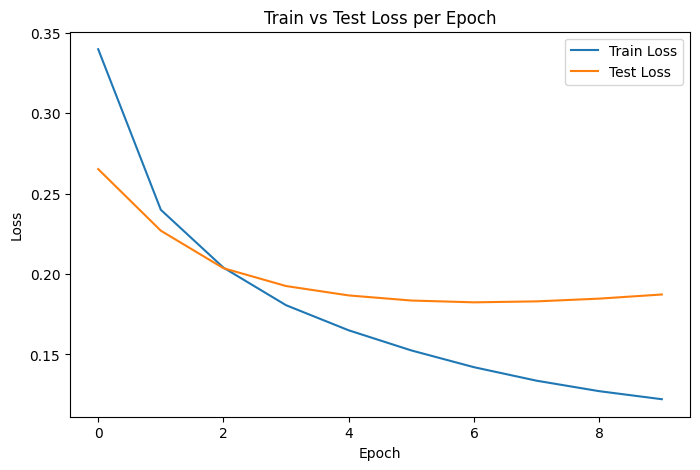

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

## Developing a BPR variant for click position debiasing

In [ ]:
from evaluation import Evaluate

In [5]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)


In [6]:
interactions["click"] = np.random.randint(0, 20, size=len(interactions))

In [7]:
interactions

,user,item,rating,relevant,click
0,1,0,5,1,9
1,1,1,3,0,18
2,1,2,3,0,7
3,1,3,4,1,7
4,1,4,5,1,19
...,...,...,...,...,...
1000204,6040,772,1,0,19
1000205,6040,1106,5,1,4
1000206,6040,365,5,1,17
1000207,6040,152,4,1,16


In [8]:

bpr_df_click = generate_bpr_dataset_with_click_data(interactions)

In [9]:
bpr_df_click

,user,pos_item,click_position,neg_item
0,1,0,9,1584
1,1,0,9,2915
2,1,0,9,2918
3,1,1,18,2526
4,1,1,18,3228
...,...,...,...,...
3000622,6040,152,16,962
3000623,6040,152,16,1793
3000624,6040,26,3,3077
3000625,6040,26,3,1873


In [10]:
from bpr_mf import bprMFLClickDebiasingDataloader, bprMF, bpr_loss_with_reg_with_debiased_click, bpr_train_with_debiasing

In [11]:
bpr_df_click

,user,pos_item,click_position,neg_item
0,1,0,9,1584
1,1,0,9,2915
2,1,0,9,2918
3,1,1,18,2526
4,1,1,18,3228
...,...,...,...,...
3000622,6040,152,16,962
3000623,6040,152,16,1793
3000624,6040,26,3,3077
3000625,6040,26,3,1873


In [12]:
data_bpr = bprMFLClickDebiasingDataloader(bpr_df_click)


train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [13]:
n_users = bpr_df_click.user.max() + 1
n_items = bpr_df_click.pos_item.max() + 1

In [14]:
model = bprMF(num_users=n_users, num_items=n_items, factors=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
TRAIN_MODEL = True

In [16]:
import pickle

if not os.path.exists('bpr_model.pkl') or TRAIN_MODEL:
    print("Model not found locally... training.")
    train_loss, test_loss = bpr_train_with_debiasing(
        train_data_loader=dataloader_bpr_train,
        test_data_loader=dataloader_bpr_test,
        model=model,
        bpr_loss=bpr_loss_with_reg_with_debiased_click,
        optimizer=optimizer,
        reg_lambda=5e-4,
        debug=True
    )
    with open('bpr_model.pkl', 'wb') as f:
        pickle.dump(model, f)

else:
    print("Model found locally... reading.")
    with open('bpr_model.pkl', 'rb') as f:
        model = pickle.load(f)

Model not found locally... training.
Train epoch mean loss: 1.067499;
 Test epoch mean loss: 0.842296; Epoch: 1/10
Train epoch mean loss: 0.737804;
 Test epoch mean loss: 0.684434; Epoch: 2/10
Train epoch mean loss: 0.612864;
 Test epoch mean loss: 0.614189; Epoch: 3/10
Train epoch mean loss: 0.538058;
 Test epoch mean loss: 0.576963; Epoch: 4/10
Train epoch mean loss: 0.481989;
 Test epoch mean loss: 0.554073; Epoch: 5/10
Train epoch mean loss: 0.435887;
 Test epoch mean loss: 0.542000; Epoch: 6/10
Train epoch mean loss: 0.398247;
 Test epoch mean loss: 0.538667; Epoch: 7/10
Train epoch mean loss: 0.368050;
 Test epoch mean loss: 0.540757; Epoch: 8/10
Train epoch mean loss: 0.344111;
 Test epoch mean loss: 0.548093; Epoch: 9/10
Train epoch mean loss: 0.324987;
 Test epoch mean loss: 0.557952; Epoch: 10/10


In [17]:
def get_candidate_items(df, u):
    user_history = list(interactions[df["user"] == u].item)
    return torch.tensor(user_history, device=device)

In [18]:
h_u =  get_candidate_items(interactions, 1)

In [19]:
test_df = dataloader_bpr_test.dataset.dataset.data

In [ ]:
bla = Evaluate(model, test_data, interactions, k=20)

/home/caio/dev/bpr-mf/bpr_mf.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.forward(torch.tensor(user, device=device), items_list)


In [ ]:
bla.MAP_at_k()

0.06459219914089076